In [15]:
#%%
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import sys
import numpy as np
import psutil
from scipy.ndimage.filters import gaussian_filter
from ipyparallel import Client

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.components_evaluation import evaluate_components
from caiman.cluster import setup_cluster

import matplotlib.pyplot as plt
import bokeh.plotting as bpl
bpl.output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1


Loading BokehJS ...

In [2]:
#%%
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

using 24 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
No cluster to stop... done


In [3]:
def gen_data(p=1, noise=1., T=256, framerate=30, firerate=2., plot=False):
    if p == 2:
        gamma = np.array([1.5, -.55])
    elif p == 1:
        gamma = np.array([.9])
    else:
        raise
    dims = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(7)
    centers = np.asarray([[np.random.randint(5, x - 5)
                           for x in dims] for i in range(N)])
    Yr = np.zeros(dims + (T,), dtype=np.float32)
    trueSpikes = np.random.rand(N, T) < firerate / float(framerate)
    trueSpikes[:, 0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2, T):
        if p == 2:
            truth[:, i] += gamma[0] * truth[:, i - 1] + gamma[1] * truth[:, i - 2]
        else:
            truth[:, i] += gamma[0] * truth[:, i - 1]
    for i in range(N):
        Yr[centers[i, 0], centers[i, 1], centers[i, 2]] = truth[i]
    tmp = np.zeros(dims)
    tmp[15, 20, 25] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(dims + (T,))) + 10 * gaussian_filter(Yr, sig + (0,)) / z
    d1, d2, d3, T = Yr.shape
    Yr = np.reshape(Yr, (d1 * d2 * d3, T), order='F').astype(np.float32)

    if plot:
        Y = np.reshape(Yr, (d1, d2, d3, T), order='F')
        plt.figure(figsize=(15, 3))
        plt.plot(truth.T)
        plt.figure(figsize=(15, 3))
        for c in centers:
            plt.plot(Y[c[0], c[1], c[2]])

        plt.figure(figsize=(15, 4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1], c='g')
        plt.imshow(Y.max(0).max(-1), cmap='hot')
        plt.title('Max.proj. x & t')
        plt.subplot(132)
        plt.scatter(*centers.T[[2, 0, 1]], c='g')
        plt.imshow(Y.max(1).max(-1), cmap='hot')
        plt.title('Max.proj. y & t')
        plt.subplot(133)
        plt.scatter(*centers.T[[1, 0, 2]], c='g')
        plt.imshow(Y.max(2).max(-1), cmap='hot')
        plt.title('Max.proj. z & t')
        plt.show()

    return Yr, truth, trueSpikes, centers, dims

In [11]:
plt.close('all')
#%% SAVING TIFF FILE ON A SINGLE MEMORY MAPPABLE FILE
try:
    fname_new = cm.save_memmap(['example_movies/demoMovie3D.tif'], base_name='Yr', is_3D=True)
except:  # %% create 3d tiff file if not yet existent
    from skimage.external.tifffile import imsave
    Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
    data = np.transpose(Yr.reshape(dims + (-1,), order='F'), [3, 0, 1, 2])
    imsave('example_movies/demoMovie3D.tif', data)
    fname_new = cm.save_memmap(['example_movies/demoMovie3D.tif'], base_name='Yr', is_3D=True)

print(fname_new)

example_movies/demoMovie3D.tif
example_movies/Yr_d1_30_d2_40_d3_50_order_F_frames_256_.mmap


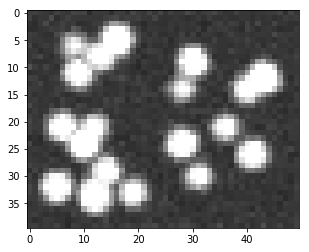

In [12]:
Yr, dims, T = cm.load_memmap(fname_new)
Y = np.reshape(Yr, dims + (T,), order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape) == 3 else Cn, cmap='gray',
           vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))
plt.show()

## Single patch: if data is small enough

In [13]:
# set parameters
K = 20  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

In [16]:
# START CLUSTER
c, dview, n_processes = setup_cluster(
    backend='local', n_processes=None, single_thread=False)

4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4999
24999
19999
39999
9999
29999
34999
59999
14999
49999
54999
44999
4999
9999
14999
19999
24999
29999
34999
39999
44999
49999
54999
59999
14999
4999
24999
9999
29999
39999
34999
19999
44999
49999
54999
59999
4999
9999
14999
19999
24999
34999
29999
44999
39999
49999
54999
59999
(256, 30, 31, 31)
using 1 processes
using 3375 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(256, 30, 31, 30)
using 1 processes
using 3375 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(256, 30, 30, 30)
using 1 processes
using 3375 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
(256, 30, 30, 31)
using 1 processes
using 3375 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
initializing ...
Noise Normalization
initializing ...


/mnt/xfs1/home/agiovann/anaconda3/envs/caiman3/lib/python3.6/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering


/mnt/xfs1/home/agiovann/anaconda3/envs/caiman3/lib/python3.6/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


USING ROLLING SUM FOR INITIALIZATION....


/mnt/xfs1/home/agiovann/anaconda3/envs/caiman3/lib/python3.6/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
parallel dot product block size: 1000
Start product
Transposing
999
(Hals) Refining Components...
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
parallel dot product block size: 1000
17999
Start product
Transposing
999
18999
19999
1999
20999
2999
21999
22999
3999
23999
4999
24999
5999
25999
6999
26999
7999
parallel dot product block size: 1000
27999
Start product
Transposing
999
8999
28829
(Hals) Refining Components...
1999
9999
2999
10999
3999
1199

In [18]:
# INIT
cnm = cnmf.CNMF(n_processes, method_init='greedy_roi', k=K, gSig=gSig, merge_thresh=merge_thresh,
                p=p, dview=dview, Ain=None, method_deconvolution='oasis')

In [19]:
# FIT
images = np.reshape(Yr.T, [T] + list(dims), order='F')
cnm = cnm.fit(images)

(256, 30, 40, 50)
using 24 processes
using 4000 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
update spatial ...
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Filling
--- 3.9426698684692383 seconds ---
Removing tempfiles created
update temporal ...
deconvolution ...
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Transposing
entering the deconvolution 
9 out of total 20 temporal components updated
17 out of total 20 temporal components updated
19 out of total 20 tempora

/mnt/xfs1/home/agiovann/anaconda3/envs/caiman3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Filling
--- 2.9383955001831055 seconds ---
Removing tempfiles created
update temporal ...
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Transposing
entering the deconvolution 
10 out of total 20 temporal components updated
18 out of total 20 temporal components updated
19 out of total 20 temporal components updated
20 out of total 20 temporal components updated
10 out of total 20 temporal components updated
18 out of total 20 temporal components updated
19 out of total 20 temporal components updated
20 out of total 20 temporal components updated
stopping: overall temporal component not changing significantly


In [20]:
# view components per layer
traces_fluo = nb_view_patches3d(cnm.YrA, cnm.A, cnm.C,dims, thr=0.9,image_type='max', max_projection=False, denoised_color='red')

## Multi patch: for larger data

In [22]:
rf = (15, 15, 15)  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = (10, 10, 10)  # amounpl.it of overlap between the patches in pixels
K = 12  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system
save_results = False
#%% RUN ALGORITHM ON PATCHES
init_method = 'greedy_roi'
alpha_snmf = None  # 10e2  # this controls sparsity

cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=p, dview=dview, Ain=None, rf=rf, stride=stride, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution='oasis')
cnm = cnm.fit(images)

A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn

print(('Number of components:' + str(A_tot.shape[-1])))

(256, 30, 40, 50)
using 24 processes
using 4000 pixels per process
using 5000 block_size
[30, 30, 30]
1.6933794021606445
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background
Compressing background components with a low rank NMF
Generating background DONE
merging


/mnt/xfs1/home/agiovann/anaconda3/envs/caiman3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[ 2 15 22 26 38]
[13 21 37 47]
[ 5 14 23 45]
[12 20 36 46]
[18 35 41]
[ 9 19 44]
[ 1 24]
[17 40]
[ 7 30]
[ 8 33]
[16 39]
[ 6 31]
[ 3 29]
[32 43]
[11 27]
[34 42]
No neurons merged!
update temporal
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Transposing
entering the deconvolution 
8 out of total 21 temporal components updated
13 out of total 21 temporal components updated
18 out of total 21 temporal components updated
21 out of total 21 temporal components updated
8 out of total 21 temporal components updated
13 out of total 21 temporal components updated
18 out of total 21 temporal components updated
21 out of total 21 temporal components updated
stopping: overall temporal component not changing significantly
Number of components:21


In [23]:
# evaluate_components
final_frate = 10  # approx final rate  (after eventual downsampling )
Npeaks = 10
traces = C_tot + YrA_tot
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(
    Y, traces, A_tot, C_tot, b_tot, f_tot, final_frate, remove_baseline=False, N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)

idx_components_r = np.where(r_values >= .7)[0]
idx_components_raw = np.where(fitness_raw < -60)[0]
idx_components_delta = np.where(fitness_delta < -20)[0]

idx_components = np.union1d(idx_components_r, idx_components_raw)
idx_components = np.union1d(idx_components, idx_components_delta)
idx_components_bad = np.setdiff1d(list(range(len(traces))), idx_components)

print(('Keeping ' + str(len(idx_components)) +
       ' and discarding  ' + str(len(idx_components_bad))))

tB:-2.0,tA:9.0
Computing event exceptionality delta
Removing Baseline
Computing event exceptionality
Evaluating spatial footprint
components evaluated:0
Keeping 20 and discarding  1


In [24]:
A_tot = A_tot.tocsc()[:, idx_components]
C_tot = C_tot[idx_components]

In [26]:
# fit good components again
cnm = cnmf.CNMF(n_processes, k=A_tot.shape, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview,
                Ain=A_tot, Cin=C_tot, f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm = cnm.fit(images)

(256, 30, 40, 50)
using 24 processes
using 4000 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
update spatial ...
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
eliminating 1 empty spatial components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Filling
--- 4.158225774765015 seconds ---
Removing tempfiles created
update temporal ...
deconvolution ...
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Transposing
entering the deconvolution 
10 out of total 20 temporal components updated
19 out of total 20 temporal components updated
20 out of total 20 temporal components updated
stopping: overall temporal component not changing significantly
refinement...
merge components ...
No neurons merged!
(60000, 20)
update spatial ...
Initializing update of Spatial Compon

/mnt/xfs1/home/agiovann/anaconda3/envs/caiman3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Filling
--- 2.785789966583252 seconds ---
Removing tempfiles created
update temporal ...
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 12]
Transposing
entering the deconvolution 
10 out of total 20 temporal components updated
19 out of total 20 temporal components updated
20 out of total 20 temporal components updated
stopping: overall temporal component not changing significantly


In [27]:
# view components per layer
traces_fluo = nb_view_patches3d(cnm.YrA, cnm.A, cnm.C, dims, Yr=Yr,
                                image_type='corr', denoised_color='green')

In [28]:
# STOP CLUSTER
cm.stop_server(dview=dview)

 done
